In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scikitplot as skplt

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn import datasets, metrics, naive_bayes
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from matplotlib.colors import ListedColormap
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import scipy.stats as stats


def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [28]:
class full_classification:
    """A class which automatically does all classification models and gridsearches for you (logisitic default). Remember to input baseline figure and decide if you want standardisation.
    Note: when you run a new model it will overwrite the previous model. You can access the current model with .model and .model_des.
    Created by LukeBetham"""

    def __init__(self, X, y, run_all=True, baseline=0, standardize=True, test_size=0.15, folds=6, shuffle=True, stratify=None,print_info=True, save_it=False, comment=None):

        # Set up the KFolds
        self.folds = folds
        self.shuffle = shuffle
        self.stratify= stratify
        # Option for bolding print text
        self.BOLD = '\033[1m'
        self.END = '\033[0m'
        # Create train-test if selected
        self.X = X
        self.y = y
        self.baseline = baseline
        self.test = test_size
        if self.test != 0:
            self.X, self.X_test, self.y, self.y_test, self.index_train, self.index_test = train_test_split(
                self.X, self.y, self.X.index, test_size=self.test, shuffle=self.shuffle, stratify=self.stratify, random_state=66)
#             self.X, self.X_test, self.y, self.y_test, self.index_train, self.index_test, self.Xf_train, self.Xf_test, self.yf_train, self.yf_test = train_test_split(
#                 self.X, self.y, self.X.index, X_flip, y_flip, test_size=self.test, shuffle=self.shuffle, stratify=self.stratify, random_state=66)
#         # Standardise the data if selected
        if standardize != 'none':
            scaler = StandardScaler()
            self.X = pd.DataFrame(
                scaler.fit_transform(self.X), columns=self.X.columns)
            if self.test != 0:
                self.X_test = pd.DataFrame(
                    scaler.transform(self.X_test), columns=self.X.columns)
#             Delete this bit when done
#             self.Xf_train = pd.DataFrame(
#                     scaler.fit_transform(self.Xf_train), columns=self.X.columns)
#             self.Xf_test = pd.DataFrame(
#                     scaler.transform(self.Xf_test), columns=self.X.columns)
        #Settings
        self.comment = comment
        self.save_it = save_it
        self.print_info = print_info
        # Call the 5 standard models
        if run_all==True:
            self.knn_model(5)
            self.decision_tree_model()
            self.logistic_model()
            self.random_forest_model()
            self.ADAboosting_model()
            self.GradientBoosting()
            self.NaiveBayes()
            self.LinearSVC()
            #only enable this one if small dataset or want to wait a while
            #self.PolynomialSVC()
            #self.GaussianSVC()


    def logistic_model(self, Logistic=LogisticRegression(fit_intercept=False)):
        # Set up Logistic Regresssion
        self.model = Logistic
        self.model_des = "Logistic Regression Model"
        self.model_calc()
        if self.print_info==True:
            print("Note: default changed to remove y-intercept for this model.")
            print("Run .coefs() to see coef dataframe\nTime Elapsed = ", round(self.elaspsed, 2),
                  'secs - grid will take ~', round(self.elaspsed*30, 2), 'minutes to run.\n')

    def knn_model(self, k='all', weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None):
        if k != 'all':
            # set up KNN model
            self.model = KNeighborsClassifier(n_neighbors=k, weights=weights, algorithm=algorithm,
                                              leaf_size=leaf_size, p=p, metric=metric, metric_params=metric_params, n_jobs=n_jobs)
            self.model_des = "K Neighbors Model"
            self.model_calc()
            if self.print_info==True:
                print("Set k='all' to run full set of ks and graph.\nTime Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~', round(
                    self.elaspsed*7, 2), 'minutes to run - and all ks', round(int(len(self.y)*(1-(1/self.folds))-1)*self.elaspsed/120, 2), 'mins\n')

        else:
            # run KNN for all possible Ks and graph them
            self.scores = []
            self.max_k = int(len(self.y)*(1-(1/self.folds))-1)
            for k in range(1, self.max_k):
                knn = KNeighborsClassifier(n_neighbors=k, weights=weights, algorithm=algorithm,
                                           leaf_size=leaf_size, p=p, metric=metric, metric_params=metric_params, n_jobs=n_jobs)
                self.scores.append(np.mean(cross_val_score(knn, self.X, self.y, cv=StratifiedKFold(
                    self.folds, shuffle=self.shuffle, random_state=66))))
            self.knn_best = self.scores.index(np.max(self.scores))+1
            plt.plot(range(1, self.max_k), self.scores, label='Mean CV Scores')
            plt.hlines(self.baseline, 1, self.max_k, label='baseline')
            plt.xlabel('k')
            plt.ylabel('accuracy')
            plt.legend(loc=[1.1, 0])
            print(self.BOLD + "Highest KNN Score:" + self.END, self.knn_best)
            plt.show()

    def decision_tree_model(self, print_tree=False, DecisionTree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=66)):
        # set up decision tree model
        self.model = DecisionTree
        self.model_des = "Decision Tree Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*50, 2), 'minutes to run.\n')
        if print_tree == True:
            dot_data = StringIO() 
            export_graphviz(self.model, out_file=dot_data, filled=True, rounded=True,
                            special_characters=True, feature_names=self.X.columns)  

            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
            display(Image(graph.create_png()))
        else:
            pass

    def random_forest_model(self, forest=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, random_state=66)):
        self.model = forest
        self.model_des = "Random Forest Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*9.5, 2), 'minutes to run.\n')

    def ADAboosting_model(self, plot_it=False, estimators=100, base_estimator=DecisionTreeClassifier(max_depth=3,random_state=66)):
        self.model = AdaBoostClassifier(
            base_estimator=base_estimator, n_estimators=estimators, algorithm='SAMME', random_state=66)
        self.model_des = "ADA Boosting Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*2.5, 2), 'minutes to run.\n')
        # plot
        if plot_it == True:
            plt.plot(list(self.model.staged_score(self.X, self.y)),
                     label='training score', lw=2)
            plt.plot(list(self.model.staged_score(
                self.X_test, self.y_test)), label='test score', lw=2)
            plt.xlabel('iteration')
            plt.ylabel('score')
            plt.legend()
            plt.show()
            
    def GradientBoosting(self, grad_model=GradientBoostingClassifier(n_estimators=100)):
        self.model = grad_model
        self.model_des = "Gradient Boosting Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*2.5, 2), 'minutes to run.\n')
    
    def NaiveBayes(self, nbtype = naive_bayes.GaussianNB(),power_transform=False):
        self.model = nbtype
        self.model_des = "Naive Bayes Model"
        if power_transform == True:
            self.X_tp, self.X_test_tp = self.X.copy(),self.X_test.copy()
            power = PowerTransformer()
            self.X = pd.DataFrame(power.fit_transform(self.X),columns=self.X_tp.columns)
            self.X_test = power.transform(self.X_test)
            self.model_des = self.model_des +" with Power Transform"
            self.model_calc()
            self.X, self.X_test = self.X_tp.copy(), self.X_test_tp.copy()
        else:
            self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*2.5, 2), 'minutes to run.\n')
    
    def LinearSVC(self,svc = LinearSVC(C=1, loss="hinge")):
        self.model = svc
        self.model_des = "Linear Support Vectors Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*0.5, 2), 'minutes to run.\n')
        
    def PolynomialSVC(self,psvc = SVC(kernel="poly", degree=3, coef0=1, C=5)):
        self.model = psvc
        self.model_des = "Polynomial Support Vectors Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*4.5, 2), 'minutes to run.\n')
        
    def GaussianSVC(self,gsvc = SVC(kernel="rbf", gamma=5, C=0.001)):
        self.model = gsvc
        self.model_des = "Gaussian (rbf) Support Vectors Model"
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*15, 2), 'minutes to run.\n')
    
    def MLP_Neural_Net(self,params = MLPClassifier(solver='adam', alpha=10**(0),
                                        hidden_layer_sizes=(10, 10, 10), activation='relu',
                                        random_state=42, batch_size=50,max_iter=500)):
        self.model = params
        self.model_des = 'MLP Classifier Neural Net'
        self.model_calc()
        if self.print_info==True:
            print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
                  round(self.elaspsed*15, 2), 'minutes to run.\n')

    def coefs(self):
        self.dfc = pd.DataFrame(self.coef, columns=self.X.columns)
        return self.dfc

    def model_calc(self):
        # fit model
        t0 = time.time()
        self.model.fit(self.X, self.y)
        self.sc = self.model.score(self.X, self.y)
        #add in some code to switch between stratified Kfold and non
        self.cvs = cross_val_score(self.model, self.X, self.y, cv=StratifiedKFold(
            self.folds, shuffle=self.shuffle, random_state=66)).mean()
        # Get test score
        if self.test != 0:
            self.sct = self.model.score(self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        else:
            self.sctp = None
        t1 = time.time()
        self.elaspsed = t1-t0
        # show the results from the classification model
        if self.print_info==True:
            print(self.BOLD + self.model_des, 'Test\nModel Score:' + self.END, round(self.sc, 4), "- better than baseline by", round(self.sc-self.baseline, 4),
                  self.BOLD + '\nCV Fold Score:' +
                  self.END, round(
                      self.cvs, 4), "- better than baseline by", round(self.cvs-self.baseline, 4),
                  self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
        try:
            self.coef = self.model.coef_
            self.coefs
        except:
            pass
#         print("Use .gridsearch() to run full regularisation tests using all default for current model.",
#               "\nUse .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.")
        if self.save_it == True:
            self.tracking()
            print("Saved model to global model tracker.")
#         DELETE WHEN DONE
  
        
    def tracking(self):
        global model_tracker
        df_temp = pd.DataFrame({'model_type':self.model_des,'model_train_score':self.sc,
                                'cv_score':self.cvs,'test_score':self.sct,'predictors': str(','.join(self.X.columns)),
                                'baseline':self.baseline,'cv_above_baseline':self.cvs-self.baseline,
                                'model_params':str(self.model),'time':self.elaspsed,'comment':self.comment},
                               index=[len(model_tracker.index)])
        model_tracker =  pd.concat([model_tracker,df_temp])

    def gridsearch(self, params='default'):
        """A function which automatically runs a gridsearch on your selected model. Returns model_grid model with best parameters.
        Defaults for Logistic (600 iterations): {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
        Defaults for KNN: self.params (100 iterations) = {'n_neighbors':range(1,20,1), 'weights':['uniform','distance'], 'p':[1,2]}         
        Defaults for Decision Tree (1000 iterations) = {'criterion':['gini','entropy'],'max_depth': [None,5,6,7,8],'max_features':['auto'],'splitter':['best','random'],'min_samples_split':[2,3,4,5],'ccp_alpha':[0.0,0.0001,0.001,.01,.1,1,10,100],'class_weight':[None,'balanced']}        
        Defaults for Random Forest (575 iterations) = {'n_estimators':[100,200,500], 'criterion':['gini':'entropy'], 'max_depth':[None], 'min_samples_split':[2,4,6],"max_features":["auto","log2"],'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha'=[0.0,0.5,1,10]}      
        Defaults for ADABoosting Model  (150 iterations)  = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], "max_depth":[1,2,3,4,5],"max_features":["auto","log2"],"n_estimators":[100,200,500]}      
                """
        # setting the default parameters if not set by user
        if params == 'default':
            if self.model_des == "Logistic Regression Model":
                self.params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
            elif self.model_des == "K Neighbors Model":
                self.params = {'n_neighbors': range(1, 20, 1), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
            elif self.model_des == "Decision Tree Model":
                self.params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': [
                    'best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, .01, .1, 1, 10, 100], 'class_weight': [None, 'balanced']}
            elif self.model_des == "Random Forest Model":
                self.params = {'n_estimators':[100,200,500], 'criterion':['gini','entropy'], 'max_depth':[None], 'min_samples_split':[2,6],"max_features":["auto","log2"],
                               'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha':[0.0,0.5,1]}
            elif self.model_des == "ADA Boosting Model": 
                self.params = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], 'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],
                               'algorithm':['SAMME'],"n_estimators":[100,200,500,1000]}
            elif self.model_des == "Gradient Boosting Model":  
                pass
            elif self.model_des == "Naive Bayes Model":
                pass
            elif self.model_des == "Linear Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,20),'loss':['hinge','squared_hinge']}
            elif self.model_des == "Gaussian (rbf) Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'gamma':np.linspace(0.00001,100,15),'kernel':['rbf']}
            elif self.model_des == "Polynomial Support Vectors Model": 
                self.params = {'C':np.linspace(-10,10,15),'coef0':[0,1,2,3,4,10],'kernel':['poly'],'degree':[2,3,4]}
        else:
            self.params = params

        # setup the gridsearch
        self.grid = GridSearchCV(self.model, self.params, verbose=1, cv=StratifiedKFold(
            self.folds, shuffle=self.shuffle, random_state=66))
        self.grid.fit(self.X, self.y)
        self.gsc = self.grid.best_score_
        self.best = self.grid.best_params_
        self.model = self.grid.best_estimator_
        self.model_des = self.model_des + " Grid Search:"
        try:
            self.coef = self.grid.best_estimator_.coef_
        except:
            pass
        # Check test score for grid
        try:
            self.sct = self.grid.best_estimator_.score(
                self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        except:
            self.sctp = None
        # Print Grid results
        if self.print_info==True:
            print(self.BOLD + self.model_des + self.END)
            print(self.BOLD + "Best Mean CV Model Score:" + self.END, round(self.gsc, 4), "- which is better than baseline by",
                  round(self.gsc-self.baseline, 4), self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
            print(self.BOLD + 'Grid Best Parameters:\n' + self.END, self.best)
            print(self.BOLD + '\nSearch Parameters:\n' + self.END, self.params)
        self.coefs()

    def matrix_n_graphs(self, normalize=True):
        print(self.BOLD + self.model_des, "on X_test" + self.END)
        self.y_pred = self.model.predict(self.X_test)
        skplt.metrics.plot_confusion_matrix(
            self.y_test, self.y_pred, figsize=(8, 8), labels=[0, 1], normalize=normalize)
        plt.xlim(-0.5, len(self.model.classes_)-0.5)
        plt.ylim(len(self.model.classes_)-0.5, -0.5)
        plt.show()
        cmap = ListedColormap(sns.color_palette("husl", 3))
        skplt.metrics.plot_roc(self.y_test, self.model.predict_proba(self.X_test), plot_micro=False,
                               plot_macro=False, title_fontsize=20, text_fontsize=16, figsize=(8, 8), cmap=cmap)
        plt.show()
        fig, ax = plt.subplots(figsize=(8, 8))
        skplt.metrics.plot_precision_recall(self.y_test, self.model.predict_proba(
            self.X_test), plot_micro=False, title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
        ax.legend(loc=[1.1, 0])
        plt.show()


In [6]:
df = pd.read_csv("all_matches_all_data3.csv")
# model_tracker = pd.read_csv('model_tracker_backup.csv')
# model_tracker.drop(model_tracker.index, inplace=True)
# model_tracker.to_csv("player_model_tracker.csv")

In [29]:
# flip the data so that have all the stats in the same place - keeping win and losses
df_nadal_w = df[(df['winner_id'] == 4742)]
df_nadal_l = df[(df['loser_id'] == 4742)]
df_nadal_w['y'] = 1
df_nadal_l['y'] = 0
df_nadal_l.columns = df_nadal_l.columns.str.replace("p1_", "p3")
df_nadal_l.columns = df_nadal_l.columns.str.replace("p2_", "p1_")
df_nadal_l.columns = df_nadal_l.columns.str.replace("p3", "p2_")
df_nadal_l.columns = df_nadal_l.columns.str.replace("winner", "p3")
df_nadal_l.columns = df_nadal_l.columns.str.replace("loser", "winner")
df_nadal_l.columns = df_nadal_l.columns.str.replace("p3", "loser")

df_nadal = pd.concat([df_nadal_w,df_nadal_l])

In [30]:
# A quick look at who beat Nadal the most

nadal_losses = pd.DataFrame(df_nadal_l.p2_last_name.value_counts())
nadal_losses = nadal_losses.join(pd.DataFrame(df_nadal_w.p2_last_name.value_counts()),rsuffix='W')
nadal_losses['ratio'] = nadal_losses.p2_last_name/nadal_losses.p2_last_nameW
nadal_losses['losses percent of all matches'] = nadal_losses.p2_last_name.apply(lambda x: x/(len(df_nadal_l)+len(df_nadal_w)))
nadal_losses

,p2_last_name,p2_last_nameW,ratio,losses percent of all matches
Djokovic,26,19.0,1.368421,0.023615
Federer,15,21.0,0.714286,0.013624
Murray,6,16.0,0.375000,0.005450
Ferrer,6,17.0,0.352941,0.005450
Davydenko,5,5.0,1.000000,0.004541
...,...,...,...,...
Mayer,1,8.0,0.125000,0.000908
Cuevas,1,5.0,0.200000,0.000908
Pouille,1,2.0,0.500000,0.000908
Schuettler,1,5.0,0.200000,0.000908


In [31]:
df_nadal.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 5313 to 94389
Data columns (total 359 columns):
Date                               object
Loser                              object
Tournament                         object
Winner                             object
best_of                            int64
city                               float64
country_id                         float64
date                               object
has_stats                          bool
indoor                             bool
l_games                            float64
l_max                              float64
l_mean                             float64
l_mean_prob                        float64
l_min                              float64
l_sets                             float64
l_tbs                              float64
last_season                        int64
level                              object
lookup                             object
loser_age                          float64
lo

In [32]:
df_nadal.y.value_counts(normalize=True)

1    0.833787
0    0.166213
Name: y, dtype: float64

In [33]:
X = df_nadal[['date', 'surface', 'indoor', 'round', 'best_of','loser_id', 'loser_country_id', 'loser_seed',
              'loser_entry', 'loser_rank', 'loser_elo_rating', 'loser_age', 'loser_height','season',
              'p2_weight', 'p2_hand', 'p2_backhand', 'p2_p_matches', 'p2_o_matches', 'p2_p_sets', 'p2_o_sets', 
              'p2_p_games', 'p2_o_games', 'p2_p_tbs', 'p2_o_tbs', 'p2_p_ace', 'p2_p_df', 'p2_p_sv_pt', 
              'p2_p_1st_in', 'p2_p_1st_won', 'p2_p_2nd_won', 'p2_p_sv_gms', 'p2_p_bp_sv', 'p2_p_bp_fc', 
              'p2_o_ace', 'p2_o_df', 'p2_o_sv_pt', 'p2_o_1st_in', 'p2_o_1st_won', 'p2_o_2nd_won', 'p2_o_sv_gms',
              'p2_o_bp_sv', 'p2_o_bp_fc', 'p2_minutes', 'p2_matches_w_stats', 'p2_opponent_rank', 
              'p2_opponent_elo_rating', 'p2_p_upsets', 'p2_o_upsets', 'p2_matches_w_rank','p2_player_id_y',
              'p2_season_y', 'p2_matches_won', 'p2_matches_lost', 'p2_grand_slam_matches_won',
              'p2_grand_slam_matches_lost', 'p2_tour_finals_matches_won', 'p2_tour_finals_matches_lost',
              'p2_alt_finals_matches_won', 'p2_alt_finals_matches_lost', 'p2_masters_matches_won',
              'p2_masters_matches_lost', 'p2_olympics_matches_won', 'p2_olympics_matches_lost',
              'p2_atp500_matches_won', 'p2_atp500_matches_lost', 'p2_atp250_matches_won', 'p2_atp250_matches_lost',
              'p2_davis_cup_matches_won', 'p2_davis_cup_matches_lost', 'p2_team_cups_matches_won',
              'p2_team_cups_matches_lost', 'p2_best_of_3_matches_won', 'p2_best_of_3_matches_lost',
              'p2_best_of_5_matches_won', 'p2_best_of_5_matches_lost', 'p2_hard_matches_won', 'p2_hard_matches_lost',
              'p2_clay_matches_won', 'p2_clay_matches_lost', 'p2_grass_matches_won', 'p2_grass_matches_lost',
              'p2_carpet_matches_won', 'p2_carpet_matches_lost', 'p2_outdoor_matches_won',
              'p2_outdoor_matches_lost', 'p2_indoor_matches_won', 'p2_indoor_matches_lost',
              'p2_deciding_sets_won', 'p2_deciding_sets_lost', 'p2_fifth_sets_won', 'p2_fifth_sets_lost',
              'p2_finals_won', 'p2_finals_lost', 'p2_vs_no1_won', 'p2_vs_no1_lost', 'p2_vs_top5_won',
              'p2_vs_top5_lost', 'p2_vs_top10_won', 'p2_vs_top10_lost', 'p2_after_winning_first_set_won',
              'p2_after_winning_first_set_lost', 'p2_after_losing_first_set_won', 'p2_after_losing_first_set_lost',
              'p2_tie_breaks_won', 'p2_tie_breaks_lost', 'p2_deciding_set_tbs_won', 'p2_deciding_set_tbs_lost',
              'p2_p_matches_all', 'p2_o_matches_all', 'p2_p_sets_all', 'p2_o_sets_all', 'p2_p_games_all',
              'p2_o_games_all', 'p2_p_tbs_all', 'p2_o_tbs_all', 'p2_p_ace_all', 'p2_p_df_all', 'p2_p_sv_pt_all',
              'p2_p_1st_in_all', 'p2_p_1st_won_all', 'p2_p_2nd_won_all', 'p2_p_sv_gms_all', 'p2_p_bp_sv_all',
              'p2_p_bp_fc_all', 'p2_o_ace_all', 'p2_o_df_all', 'p2_o_sv_pt_all', 'p2_o_1st_in_all',
              'p2_o_1st_won_all', 'p2_o_2nd_won_all', 'p2_o_sv_gms_all', 'p2_o_bp_sv_all', 'p2_o_bp_fc_all',
              'p2_minutes_all', 'p2_matches_w_stats_all', 'p2_opponent_rank_all', 'p2_opponent_elo_rating_all',
              'p2_p_upsets_all', 'p2_o_upsets_all', 'p2_matches_w_rank_all', 'p1_beat_p2_overall',
              'p2_beat_p1_overall', 'p1_pct_overall', 'p2_pct_overall','p1_beat_p2_overall_all', 
              'p2_beat_p1_overall_all', 'p1_pct_overall_all', 'p2_pct_overall_all','y']]


In [34]:
# sorting NANs
# filling loser seed with lowest possible seed
X.loser_seed=X.loser_seed.fillna(34)
X.loser_entry=X.loser_entry.fillna("None")
X.loser_height=X.loser_height.fillna(np.mean(X.loser_height))
# backhand should be binarized
X.p2_backhand=X.p2_backhand.fillna(2)
X.dropna(subset=['p2_p_ace'],inplace=True)
X.drop(["p2_weight",'loser_id'],axis=1,inplace=True)
X = X.fillna(0)
X['date'] = pd.to_datetime(X['date'])
X.sort_values(by='date',inplace=True)
date = X.pop('date')
print(len(X.columns))
# binarize
X = pd.get_dummies(X,columns=['surface', 'indoor', 'round','best_of','loser_country_id','loser_entry',
                          'p2_hand','p2_backhand','season'],drop_first=True)

147


In [35]:
# # correlation plots 
# X1=X.iloc[:,:50]
# X2=X.iloc[:,50:100]
# X3=X.iloc[:,100:150]
# X4=X.iloc[:,150:]
# X1['y']=y
# X2['y']=y
# X3['y']=y
# X4['y']=y


# for subset in [X1,X2,X3,X4]:
#     corr = subset.corr()
#     mask = np.triu(np.ones_like(corr, dtype=np.bool))
#     f, ax = plt.subplots(figsize=(26, 20))
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     sns.set(font_scale=1.5)
#     sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#                 square=True, linewidths=.1, cbar_kws={"shrink": .5});

In [36]:
y = X.pop('y')
X.reset_index(drop=True,inplace=True)
X.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 225 columns):
loser_seed                         1038 non-null float64
loser_rank                         1038 non-null float64
loser_elo_rating                   1038 non-null float64
loser_age                          1038 non-null float64
loser_height                       1038 non-null float64
p2_p_matches                       1038 non-null float64
p2_o_matches                       1038 non-null float64
p2_p_sets                          1038 non-null float64
p2_o_sets                          1038 non-null float64
p2_p_games                         1038 non-null float64
p2_o_games                         1038 non-null float64
p2_p_tbs                           1038 non-null float64
p2_o_tbs                           1038 non-null float64
p2_p_ace                           1038 non-null float64
p2_p_df                            1038 non-null float64
p2_p_sv_pt                         10

In [37]:
nadal_model = full_classification(X,y,True,0.833,folds=2,test_size=0.10,
                                  save_it=False,shuffle=True,comment="1.2 - adding in season")


K Neighbors Model Test
Model Score: 0.8597 - better than baseline by 0.0267 
CV Fold Score: 0.8212 - better than baseline by -0.0118 
Model Test Score: 0.8365 - better than baseline by 0.0035
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.51 secs - grid will take ~ 3.55 minutes to run - and all ks 1.97 mins

Decision Tree Model Test
Model Score: 1.0 - better than baseline by 0.167 
CV Fold Score: 0.7559 - better than baseline by -0.0771 
Model Test Score: 0.75 - better than baseline by -0.083
Time Elapsed =  0.12 secs - grid will take ~ 5.99 minutes to run.

Logistic Regression Model Test
Model Score: 0.7998 - better than baseline by -0.0332 
CV Fold Score: 0.6734 - better than baseline by -0.1596 
Model Test Score: 0.7115 - better than baseline by -0.1215
Note: default changed to remove y-intercept for this model.
Run .coefs() to see coef dataframe
Time Elapsed =  0.09 secs - grid will take ~ 2.62 minutes to run.

Random Forest Model Test
Model Score: 1.0 - better than

In [38]:
nadal_model.MLP_Neural_Net()

MLP Classifier Neural Net Test
Model Score: 0.9904 - better than baseline by 0.1574 
CV Fold Score: 0.803 - better than baseline by -0.03 
Model Test Score: 0.8173 - better than baseline by -0.0157
Time Elapsed =  3.86 secs - grid will take ~ 57.91 minutes to run.



In [345]:
features = pd.DataFrame(nadal_model.model.feature_importances_)
features['colname'] = X.columns

In [346]:
features.sort_values(by=0).tail(10)

,0,colname
93,0.025469,p2_tie_breaks_lost
72,0.026840,p2_outdoor_matches_won
22,0.027251,p2_o_ace
126,0.028498,p2_p_upsets_all
52,0.030064,p2_atp500_matches_won
3,0.031390,loser_age
27,0.033137,p2_o_2nd_won
138,0.038162,surface_H
39,0.055189,p2_season_y
2,0.154968,loser_elo_rating


Linear Support Vectors Model on X_test


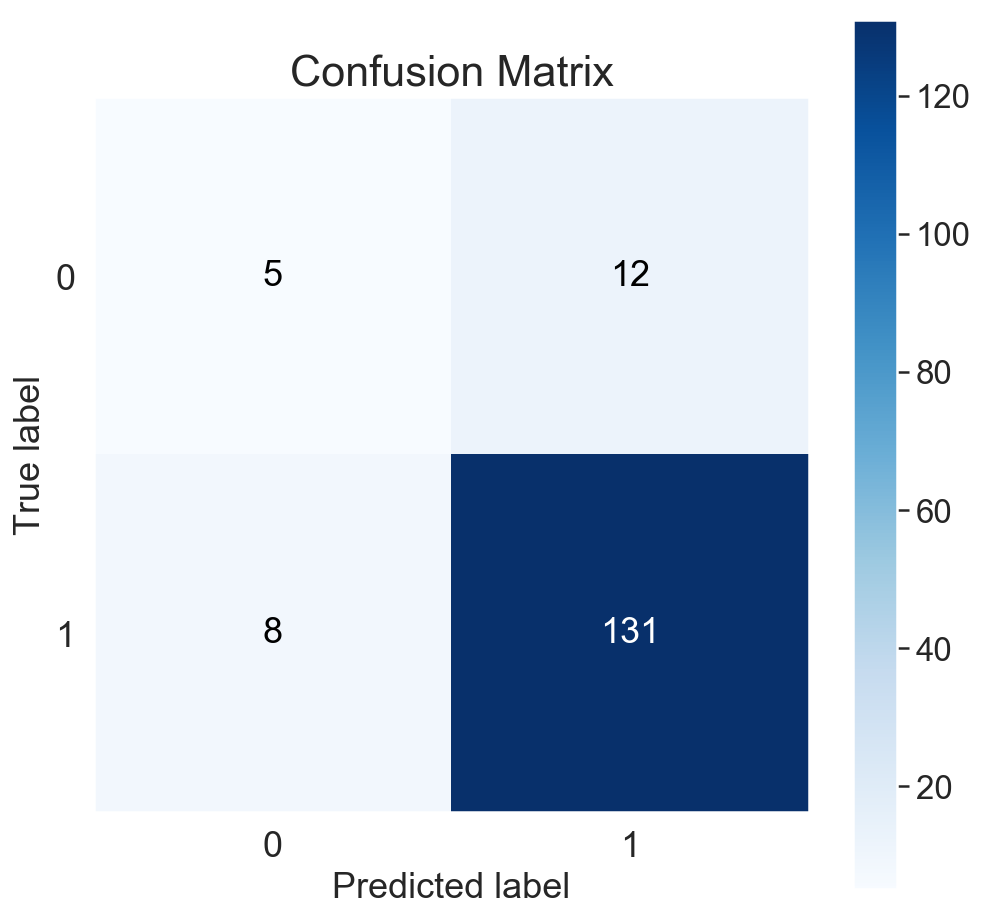

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [361]:
nadal_model.matrix_n_graphs(normalize=False)

In [348]:
model_tracker

,Usable,baseline,comment,cv_above_baseline,cv_score,info,model_params,model_train_score,model_type,predictors,test_score,time
0,NaN,0.833,First Nadal Model - all opponent data,-0.025693,0.807307,NaN,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.850340,K Neighbors Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.884615,0.522102
1,NaN,0.833,First Nadal Model - all opponent data,-0.072248,0.760752,NaN,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1.000000,Decision Tree Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.801282,0.260661
2,NaN,0.833,First Nadal Model - all opponent data,-0.291001,0.541999,NaN,"LogisticRegression(C=1.0, class_weight=None, d...",0.785714,Logistic Regression Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.794872,0.179898
3,NaN,0.833,First Nadal Model - all opponent data,-0.006447,0.826553,NaN,"RandomForestClassifier(bootstrap=True, ccp_alp...",1.000000,Random Forest Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.903846,1.646929
4,NaN,0.833,First Nadal Model - all opponent data,-0.024583,0.808417,NaN,"AdaBoostClassifier(algorithm='SAMME',\n ...",0.998866,ADA Boosting Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.897436,7.409171
5,NaN,0.833,First Nadal Model - all opponent data,-0.010972,0.822028,NaN,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.943311,Gradient Boosting Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.871795,6.416259
6,NaN,0.833,First Nadal Model - all opponent data,-0.563075,0.269925,NaN,"GaussianNB(priors=None, var_smoothing=1e-09)",0.268707,Naive Bayes Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.173077,0.027264
7,NaN,0.833,First Nadal Model - all opponent data,-0.054036,0.778964,NaN,"LinearSVC(C=1, class_weight=None, dual=True, f...",0.873016,Linear Support Vectors Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.891026,0.652992
8,NaN,0.833,First Nadal Model - all opponent data,-0.072248,0.760752,NaN,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1.000000,Decision Tree Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.801282,0.287269
9,NaN,0.833,First Nadal Model - all opponent data,-0.072248,0.760752,NaN,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1.000000,Decision Tree Model,"loser_seed,loser_rank,loser_elo_rating,loser_a...",0.801282,0.247552


In [360]:
model_tracker.to_csv("player_model_tracker.csv",index=False)